## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Author </h1>

Билинский Норгей, гр. 932328

### Задание 2. Обучение нейросетевых моделей классификации изображений и визуализация в глубоком обучении.

Цель работы:  получить навыки создания и обучения нейронных сетей для классификации изображений, переноса обучения,  визуализации активации карт признаков нейросети.

Задачи:

1. Использовать набор данных выбранный в предыдущей лабораторной.

2. Создать нейронную сеть – многоклассовый классификатор с использованием сверточной основы, обученной ранее на ImageNet (ResNet, VGG, Inception, Xception и т.д.). Выполнить дообучение модели в двух вариантах: заключительные полносвязные слои и fine-tuning.

3. Привести кривые изменения функции потерь (Loss) и верности (Accuracy) во время обучения на обучающем и валидационном наборах из трех+ классов.

4. Выполнить аугментацию данных (с использованием сгенерированного набора из 1й лабораторной) и провести повторное обучение на новом расширенном наборе.

4. Визуализировать промежуточные активации для изображений из выборки (по одному изображений из каждого класса).

5. Визуализировать фильтры сверточной нейронной сети.

6. Визуализировать тепловые карты активации классов на изображениях с помощью Grad-CAM и значений Шепли (image_plot).

## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Importing libraries </h1>

In [35]:
!pip install opendatasets
!pip install shap


In [36]:
import gc
import os
import random
import shutil
from pathlib import Path

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import opendatasets as od
import tensorflow as tf
import shap
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img,
)


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Checking the GPU environment </h1>

In [3]:
!nvidia-smi


Thu Jan 30 01:43:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Data download </h1>

### <h1 id="aa" style="color:white;background:#42aaff;padding:8px;border-radius:8px;font-family:newtimeroman;"> original dataset </h1>

In [4]:
dataset_path = Path('stanford-dogs-dataset')
if not dataset_path.is_file():
    od.download('https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset')


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: norgey
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset


100%|██████████| 750M/750M [00:07<00:00, 98.7MB/s]


In [5]:
data_path = Path('stanford-dogs-dataset/images/Images')
train_path = Path('stanford-dogs-dataset/Train')

if not data_path.exists():
    print(f"Error: The specified data path '{data_path}' does not exist.")
    exit()

folders = [f for f in data_path.iterdir() if f.is_dir()]
folder_counts = []
for folder in folders:
    image_count = len(list(folder.glob('*')))
    folder_counts.append((folder, image_count))

# Сортируем папки по убыванию количества картинок
folder_counts.sort(key=lambda item: item[1], reverse=True)
# Выбираем 4 папки с наибольшим количеством картинок
top_4_folders = folder_counts[:4]

print("Top 4 folders with most images:")
for folder, count in top_4_folders:
    print(f"{folder.name}: {count}")

# Создаем папку Train, если она не существует
train_path.mkdir(exist_ok=True)
# Копируем 4 папки в train_path и переименовываем их
for folder, _ in top_4_folders:
    new_folder_name = folder.name.split('-', 1)[1] if '-' in folder.name else folder.name
    new_folder_path = train_path / new_folder_name
    shutil.copytree(folder, new_folder_path)
    print(f"Copied and renamed '{folder.name}' to '{new_folder_name}' in '{train_path}'")


Top 4 folders with most images:
n02085936-Maltese_dog: 252
n02088094-Afghan_hound: 239
n02092002-Scottish_deerhound: 232
n02112018-Pomeranian: 219
Copied and renamed 'n02085936-Maltese_dog' to 'Maltese_dog' in 'stanford-dogs-dataset/Train'
Copied and renamed 'n02088094-Afghan_hound' to 'Afghan_hound' in 'stanford-dogs-dataset/Train'
Copied and renamed 'n02092002-Scottish_deerhound' to 'Scottish_deerhound' in 'stanford-dogs-dataset/Train'
Copied and renamed 'n02112018-Pomeranian' to 'Pomeranian' in 'stanford-dogs-dataset/Train'


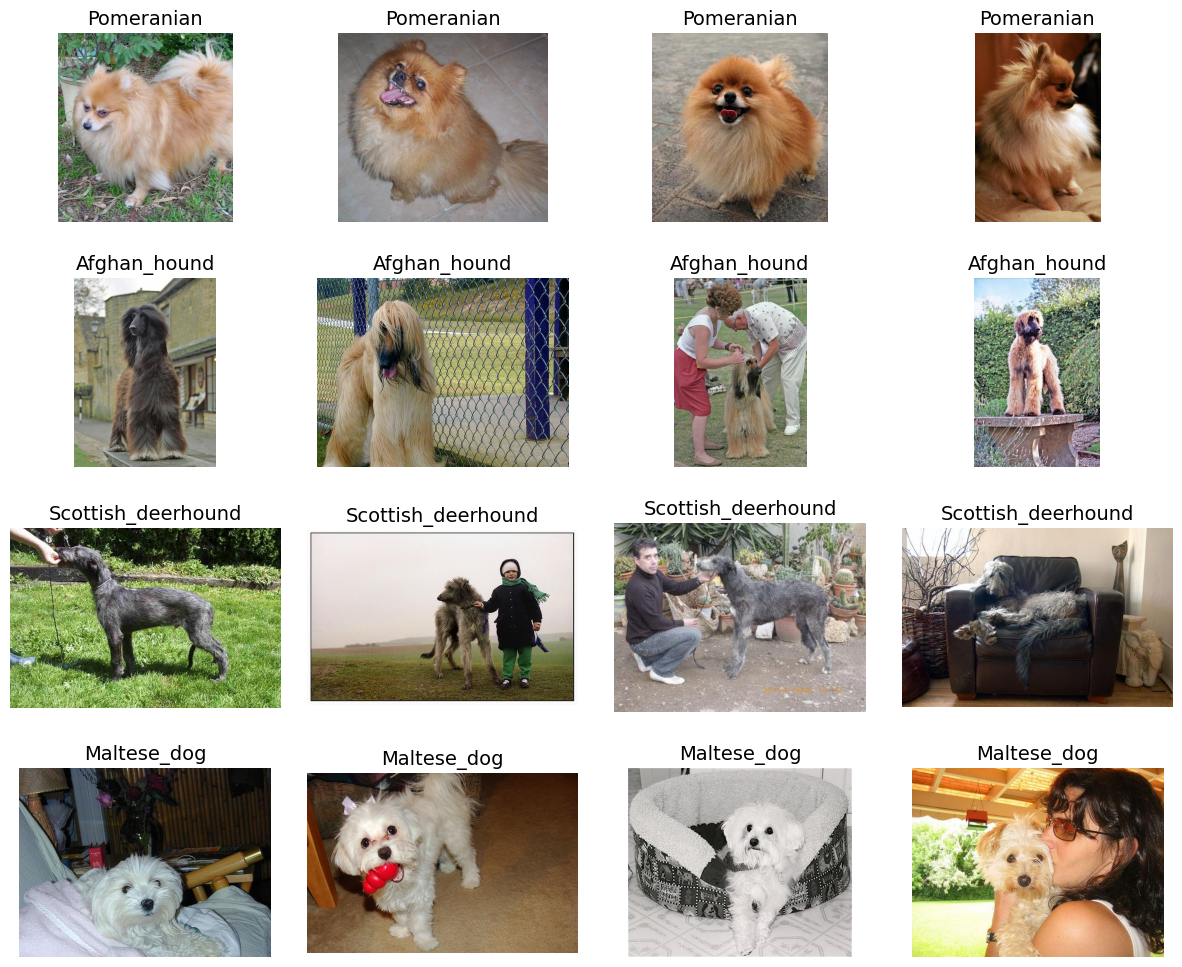

In [6]:
fig, axes = plt.subplots(4, 4, figsize=(15, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.1)

axes = axes.flat #Делаем одномерный массив для итерации
for i, folder in enumerate(train_path.iterdir()):
    if not folder.is_dir():
        continue  # Пропускаем, если это не папка

    images = list(folder.glob('*.*'))
    images = [img for img in images if img.suffix.lower() in ['.jpg', '.jpeg', '.png']]

    if len(images) < 4:
      print(f"Warning: Folder '{folder.name}' has less than 5 images.")
      continue

    random_images = random.sample(images, 4)

    for j, img_path in enumerate(random_images):
      ax_index = i * 4 + j #высчитываем индекс для оси
      ax = axes[ax_index]
      img = Image.open(img_path)
      ax.imshow(img)
      ax.axis('off')
      ax.set_title(f"{folder.name}", fontsize = 14)

for ax in axes[len(list(train_path.iterdir()))*4:]:
    ax.remove()
plt.show()


### <h1 id="aa" style="color:white;background:#42aaff;padding:8px;border-radius:8px;font-family:newtimeroman;"> generated dataset </h1>

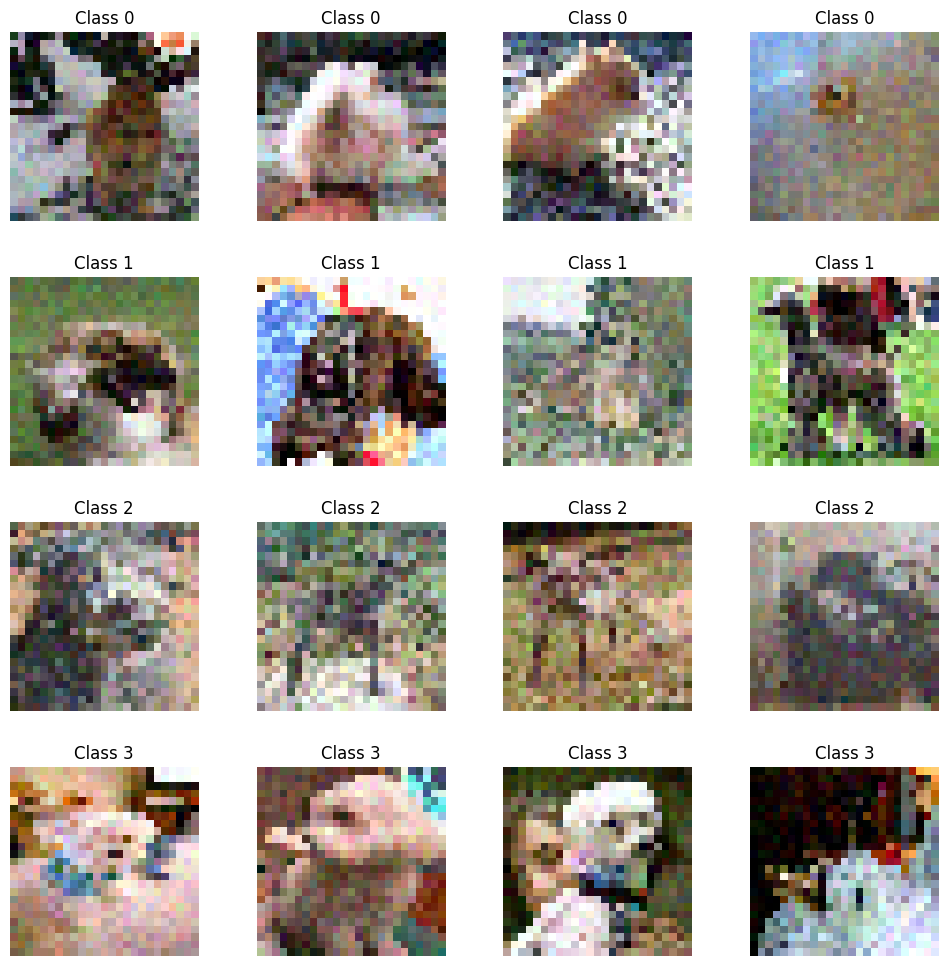

In [12]:
PATH_DATA = '/content/drive/My Drive/Университет/Глубокое обучение/Generation images'
LOCAL_DATA_PATH = 'generated_data'

os.makedirs(LOCAL_DATA_PATH, exist_ok=True)

for class_idx in range(len([f for f in train_path.iterdir() if f.is_dir()])):
    class_path_drive = os.path.join(PATH_DATA, f'class_{class_idx}')
    class_path_local = os.path.join(LOCAL_DATA_PATH, f'class_{class_idx}')

    if os.path.exists(class_path_drive):
      shutil.copytree(class_path_drive, class_path_local)

add_path = Path(LOCAL_DATA_PATH)

fig, axes = plt.subplots(4, 4, figsize=(15, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.1)

axes = axes.flat  # Делаем одномерный массив для итерации
folder_counter = 0
for i, folder in enumerate(add_path.iterdir()):
    if not folder.is_dir():
        continue  # Пропускаем, если это не папка

    images = list(folder.glob('*.*'))
    images = [img for img in images if img.suffix.lower() in ['.jpg', '.jpeg', '.png']]

    if len(images) < 4:
        print(f"Warning: Folder '{folder.name}' has less than 4 images.")
        continue

    random_images = random.sample(images, 4)

    for j, img_path in enumerate(random_images):
        ax_index = folder_counter * 4 + j
        ax = axes[ax_index]
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{folder.name}", fontsize=14)
    folder_counter += 1

plt.show()


In [13]:
# Сохраним объединённый датасет из изначальных и сгенерированых фото в отдельную директорию Add_Train
path = Path('stanford-dogs-dataset/Train')
add_path = Path('stanford-dogs-dataset/Add_Train')

os.makedirs(add_path, exist_ok=True)

for item in path.iterdir():
    dest_item = add_path / item.name

    if item.is_file():
        shutil.copy2(item, dest_item) # shutil.copy2 сохраняет метаданные
    elif item.is_dir():
        # Если это папка, копируем ее рекурсивно
        shutil.copytree(item, dest_item)


add_path_folders = [f for f in add_path.iterdir() if f.is_dir()]

for class_folder in [f for f in Path(LOCAL_DATA_PATH).iterdir() if f.is_dir()]:
    class_name = class_folder.name

    matching_add_folder = next((f for f in add_path_folders if f.name == class_name), None)

    if matching_add_folder:
         for item in class_folder.iterdir():
            dest_item = matching_add_folder / item.name
            if item.is_file():
                shutil.copy2(item, dest_item)


stanford-dogs-dataset/Add_Train/Scottish_deerhound
stanford-dogs-dataset/Add_Train/Scottish_deerhound
stanford-dogs-dataset/Add_Train/Scottish_deerhound
stanford-dogs-dataset/Add_Train/Scottish_deerhound
stanford-dogs-dataset/Add_Train/Scottish_deerhound
stanford-dogs-dataset/Add_Train/Scottish_deerhound
stanford-dogs-dataset/Add_Train/Scottish_deerhound
stanford-dogs-dataset/Add_Train/Scottish_deerhound
stanford-dogs-dataset/Add_Train/Scottish_deerhound
stanford-dogs-dataset/Add_Train/Scottish_deerhound
stanford-dogs-dataset/Add_Train/Scottish_deerhound
stanford-dogs-dataset/Add_Train/Scottish_deerhound
stanford-dogs-dataset/Add_Train/Scottish_deerhound
stanford-dogs-dataset/Add_Train/Scottish_deerhound
stanford-dogs-dataset/Add_Train/Scottish_deerhound
stanford-dogs-dataset/Add_Train/Scottish_deerhound
stanford-dogs-dataset/Add_Train/Scottish_deerhound
stanford-dogs-dataset/Add_Train/Scottish_deerhound
stanford-dogs-dataset/Add_Train/Scottish_deerhound
stanford-dogs-dataset/Add_Train

## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Data preparation </h1>

### <h1 id="aa" style="color:white;background:#42aaff;padding:8px;border-radius:8px;font-family:newtimeroman;"> original dataset </h1>

In [8]:
IMG_HEIGHT = 32
IMG_WIDTH = 32
NUM_CLASSES = len([f for f in train_path.iterdir() if f.is_dir()])

# Функция для загрузки и подготовки изображений
def preprocess_image(image_path):
    # Загрузка изображения и изменение размера
    image = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    # Преобразование изображения в массив numpy
    image = img_to_array(image)
    # Нормализация в диапазон от -1 до +1
    image = (image.astype(np.float32) - 127.5) / 127.5
    return image

def augment_image(image):
    # Отражение по горизонтали (случайно)
    if random.random() > 0.5:
        image = np.fliplr(image)

    # Изменение освещения (случайное изменение яркости)
    brightness_factor = random.uniform(0.9, 1.1)
    image = np.clip(image * brightness_factor, -1, 1)  # Учитываем новый диапазон

    # Добавление шума
    noise = np.random.normal(0, 0.01, image.shape)
    image = np.clip(image + noise, -1, 1)  # Учитываем новый диапазон

    return image

# Функция для загрузки и подготовки данных
def load_data(path, augment=False):
    images = []
    labels = []

    for class_idx, class_folder in enumerate(path.glob('*')):
        if class_folder.is_dir():
            image_files = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.png'))

            for img_path in image_files:
                image = preprocess_image(img_path)

                if augment:
                    image = augment_image(image)

                images.append(image)
                labels.append(class_idx)  # Целочисленные метки 0,1,2,3

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

all_images, all_labels = load_data(train_path, augment=True)

train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

val_images, test_images, val_labels, test_labels = train_test_split(
    test_images, test_labels, test_size=0.5, random_state=42, stratify=test_labels)

print('train_images.shape:', train_images.shape)
print('val_images.shape:', val_images.shape)
print('test_images.shape:', test_images.shape)

print('Уникальные метки классов (train):', np.unique(train_labels))
print('Уникальные метки классов (val):', np.unique(val_labels))
print('Уникальные метки классов (test):', np.unique(test_labels))


train_images.shape: (753, 32, 32, 3)
val_images.shape: (94, 32, 32, 3)
test_images.shape: (95, 32, 32, 3)
Уникальные метки классов (train): [0 1 2 3]
Уникальные метки классов (val): [0 1 2 3]
Уникальные метки классов (test): [0 1 2 3]


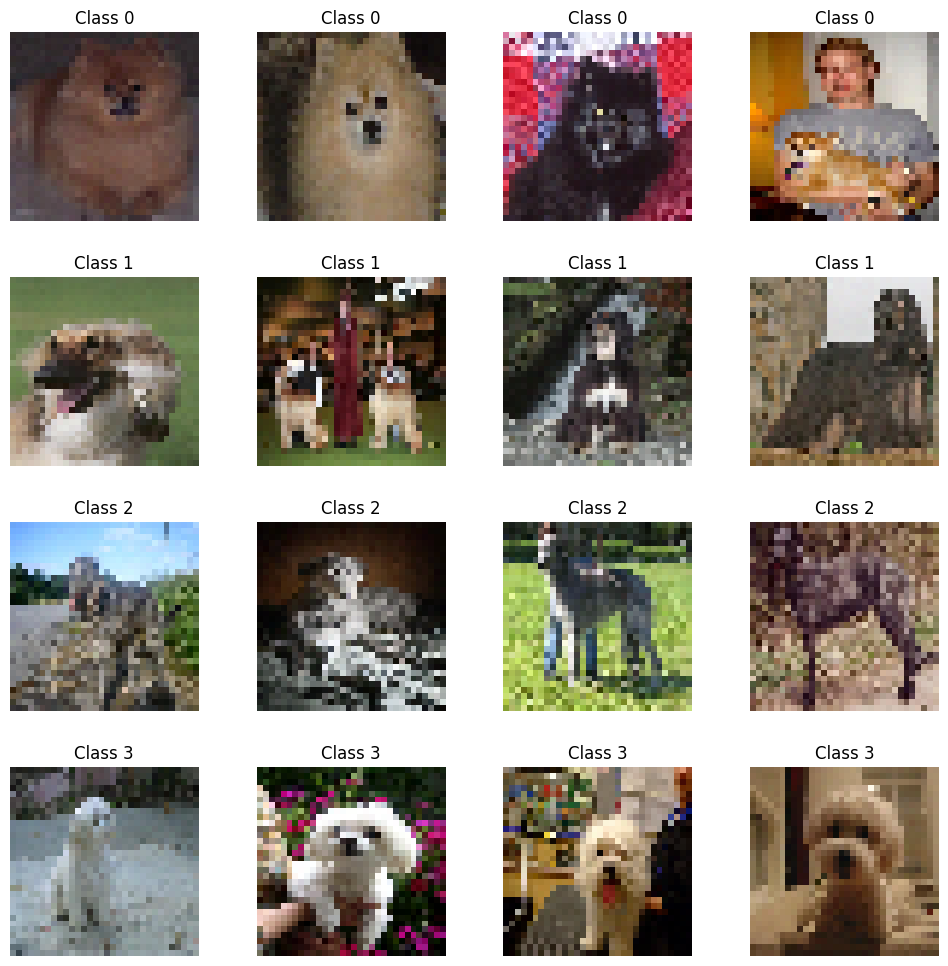

In [9]:
def display_images(images, labels, num_classes=4, samples_per_class=4):
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(12, 12))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    # Для каждого класса
    for class_idx in range(num_classes):
        # Находим индексы изображений, принадлежащих текущему классу
        class_indices = np.where(labels == class_idx)[0]

        # Если изображений для класса недостаточно, пропускаем
        if len(class_indices) < samples_per_class:
            print(f"Недостаточно изображений для класса {class_idx}. Пропускаем.")
            continue

        # Выбираем случайные изображения для отображения
        selected_indices = np.random.choice(class_indices, samples_per_class, replace=False)

        # Отображаем изображения
        for j, img_idx in enumerate(selected_indices):
            ax = axes[class_idx, j]
            # Преобразуем значения пикселей из [-1, 1] в [0, 1]
            image = (images[img_idx] + 1) / 2.0
            ax.imshow(image)  # Отображаем изображение
            ax.axis('off')  # Убираем оси
            ax.set_title(f"Class {class_idx}")  # Подпись с классом

    plt.show()

# Вызываем функцию для отображения изображений
display_images(train_images, train_labels, num_classes=4, samples_per_class=4)


### <h1 id="aa" style="color:white;background:#42aaff;padding:8px;border-radius:8px;font-family:newtimeroman;"> united dataset </h1>

In [14]:
IMG_HEIGHT = 32
IMG_WIDTH = 32
NUM_CLASSES = len([f for f in add_path.iterdir() if f.is_dir()])

# Функция для загрузки и подготовки изображений
def preprocess_image(image_path):
    # Загрузка изображения и изменение размера
    image = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    # Преобразование изображения в массив numpy
    image = img_to_array(image)
    # Нормализация в диапазон от -1 до +1
    image = (image.astype(np.float32) - 127.5) / 127.5
    return image

def augment_image(image):
    # Отражение по горизонтали (случайно)
    if random.random() > 0.5:
        image = np.fliplr(image)

    # Изменение освещения (случайное изменение яркости)
    brightness_factor = random.uniform(0.9, 1.1)
    image = np.clip(image * brightness_factor, -1, 1)  # Учитываем новый диапазон

    # Добавление шума
    noise = np.random.normal(0, 0.01, image.shape)
    image = np.clip(image + noise, -1, 1)  # Учитываем новый диапазон

    return image

# Функция для загрузки и подготовки данных
def load_data(path, augment=False):
    images = []
    labels = []

    for class_idx, class_folder in enumerate(path.glob('*')):
        if class_folder.is_dir():
            image_files = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.png'))

            for img_path in image_files:
                image = preprocess_image(img_path)

                if augment:
                    image = augment_image(image)

                images.append(image)
                labels.append(class_idx)  # Целочисленные метки 0,1,2,3

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

all_images_2, all_labels_2 = load_data(add_path, augment=False)

train_images_2, test_images_2, train_labels_2, test_labels_2 = train_test_split(
    all_images_2, all_labels_2, test_size=0.2, random_state=42, stratify=all_labels_2)

val_images_2, test_images_2, val_labels_2, test_labels_2 = train_test_split(
    test_images_2, test_labels_2, test_size=0.5, random_state=42, stratify=test_labels_2)

print('train_images_2.shape:', train_images_2.shape)
print('val_images_2.shape:', val_images_2.shape)
print('test_images_2.shape:', test_images_2.shape)

print('Уникальные метки классов (train):', np.unique(train_labels_2))
print('Уникальные метки классов (val):', np.unique(val_labels_2))
print('Уникальные метки классов (test):', np.unique(test_labels_2))


train_images_2.shape: (1507, 32, 32, 3)
val_images_2.shape: (188, 32, 32, 3)
test_images_2.shape: (189, 32, 32, 3)
Уникальные метки классов (train): [0 1 2 3]
Уникальные метки классов (val): [0 1 2 3]
Уникальные метки классов (test): [0 1 2 3]


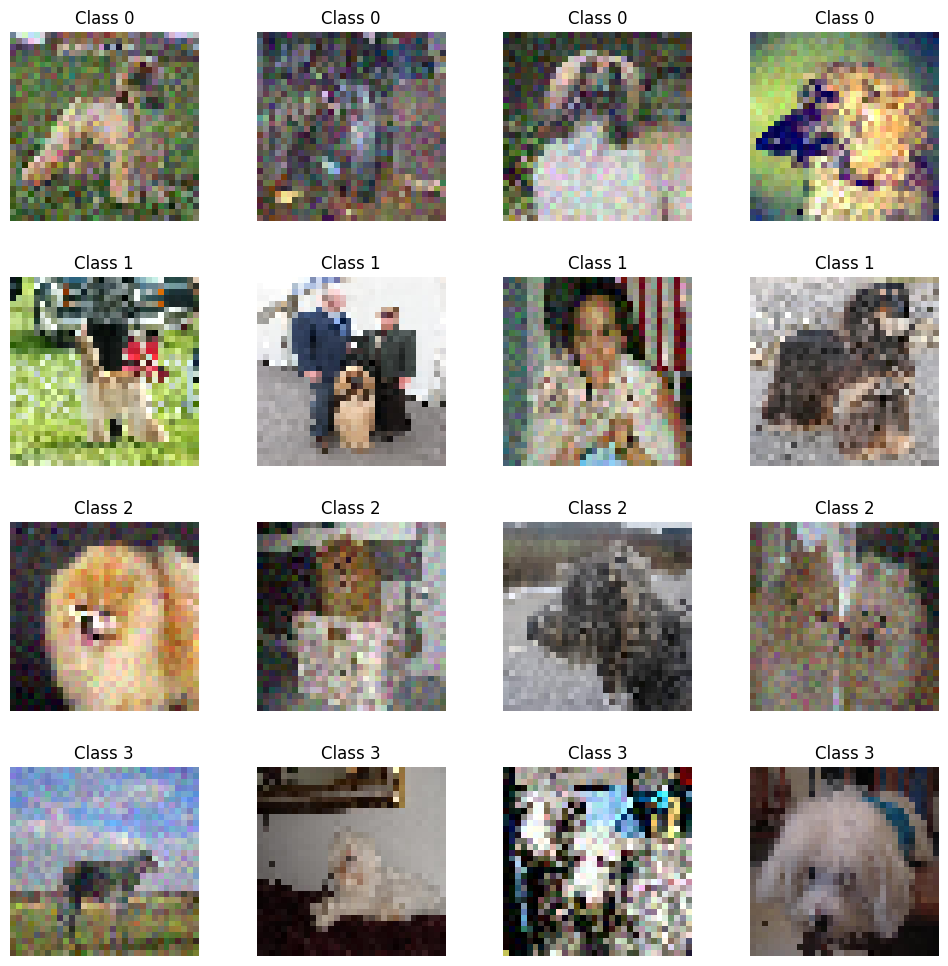

In [16]:
def display_images(images, labels, num_classes=4, samples_per_class=4):
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(12, 12))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    # Для каждого класса
    for class_idx in range(num_classes):
        # Находим индексы изображений, принадлежащих текущему классу
        class_indices = np.where(labels == class_idx)[0]

        # Если изображений для класса недостаточно, пропускаем
        if len(class_indices) < samples_per_class:
            print(f"Недостаточно изображений для класса {class_idx}. Пропускаем.")
            continue

        # Выбираем случайные изображения для отображения
        selected_indices = np.random.choice(class_indices, samples_per_class, replace=False)

        # Отображаем изображения
        for j, img_idx in enumerate(selected_indices):
            ax = axes[class_idx, j]
            # Преобразуем значения пикселей из [-1, 1] в [0, 1]
            image = (images[img_idx] + 1) / 2.0
            ax.imshow(image)  # Отображаем изображение
            ax.axis('off')  # Убираем оси
            ax.set_title(f"Class {class_idx}")  # Подпись с классом

    plt.show()

display_images(train_images_2, train_labels_2, num_classes=4, samples_per_class=4)


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> ResNet training on the original dataset </h1>


In [17]:
def plot_history(history, title):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(title)
    plt.show()


### <h1 id="aa" style="color:white;background:#42aaff;padding:8px;border-radius:8px;font-family:newtimeroman;"> 1a frozen weights</h1>


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.2437 - loss: 1.8118Epoch 1/100 - loss: 1.6223 - accuracy: 0.2569 - val_loss: 1.3784 - val_accuracy: 0.2979
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 467ms/step - accuracy: 0.2441 - loss: 1.8057 - val_accuracy: 0.2979 - val_loss: 1.3784
Epoch 2/100
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2708 - loss: 1.4555Epoch 2/100 - loss: 1.4530 - accuracy: 0.2473 - val_loss: 1.3871 - val_accuracy: 0.2660
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2686 - loss: 1.4553 - val_accuracy: 0.2660 - val_loss: 1.3871
Epoch 3/100
24/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2694 - loss: 1.3922Epoch 3/100 - loss: 1.4133 - accuracy: 0.2367 - val_loss: 1.3863 - val_accuracy: 0.2340
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2628 - loss: 1.3967 - val_accuracy: 0.2340 - val_loss: 1.3863
Epoch 4/100
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2612 - loss: 1

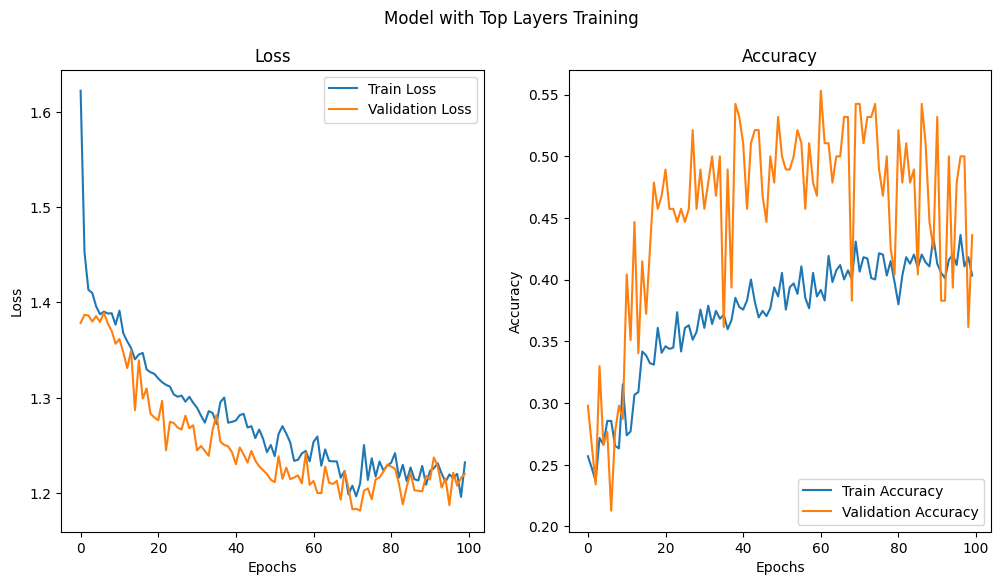

In [18]:
EPOCHS = 100
BATCH_SIZE = 32
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)  # Форма изображений
NUM_CLASSES = len([f for f in train_path.iterdir() if f.is_dir()])

# Загрузка предварительно обученной модели ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

# Заморозим все слои
base_model.trainable = False

# Добавление новых полносвязных слоев
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

class EpochMetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{EPOCHS} - loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")

model_1a = Model(inputs=base_model.input, outputs=predictions)
model_1a.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_1a = model_1a.fit(
    train_images,
    train_labels,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(val_images, val_labels),
    callbacks=[EpochMetricsCallback()]
    )

test_loss, test_accuracy = model_1a.evaluate(test_images, test_labels, verbose=0)
print('---' * 30)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

plot_history(history_1a, 'Model with Top Layers Training')


### <h1 id="aa" style="color:white;background:#42aaff;padding:8px;border-radius:8px;font-family:newtimeroman;"> 1b fine-tuning</h1>


Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.2240 - loss: 2.0452Epoch 1/100 - loss: 1.8020 - accuracy: 0.2495 - val_loss: 2.2306 - val_accuracy: 0.2447
30/30 ━━━━━━━━━━━━━━━━━━━━ 94s 990ms/step - accuracy: 0.2249 - loss: 2.0374 - val_accuracy: 0.2447 - val_loss: 2.2306
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2769 - loss: 1.5341Epoch 2/100 - loss: 1.5704 - accuracy: 0.2898 - val_loss: 2.3205 - val_accuracy: 0.2340
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2773 - loss: 1.5353 - val_accuracy: 0.2340 - val_loss: 2.3205
Epoch 3/100
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3276 - loss: 1.4994Epoch 3/100 - loss: 1.4881 - accuracy: 0.3227 - val_loss: 1.4934 - val_accuracy: 0.2340
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3273 - loss: 1.4987 - val_accuracy: 0.2340 - val_loss: 1.4934
Epoch 4/100
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3120 - loss: 1.4587Epoch 4/100 - loss: 1.4151 - accuracy: 0.3333

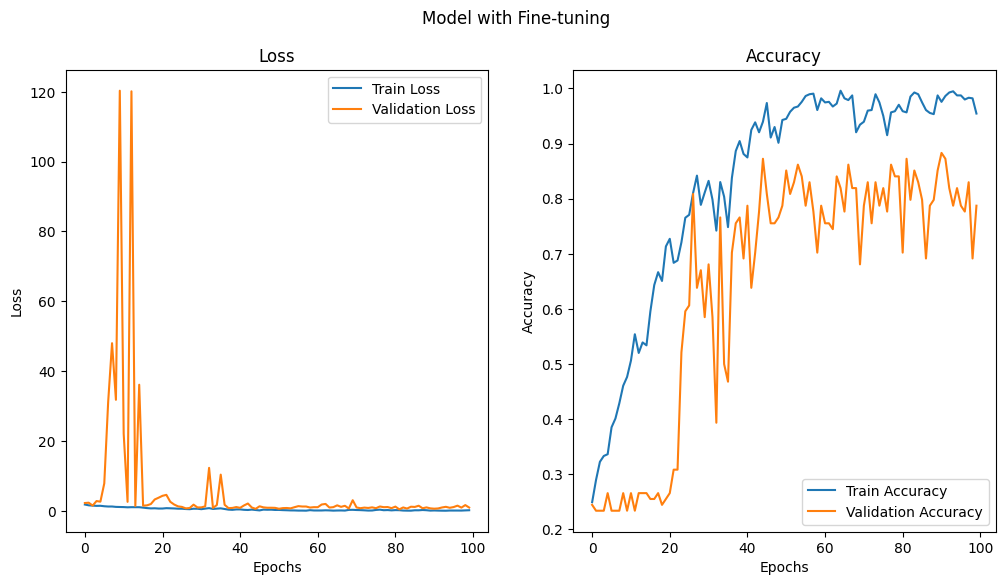

In [19]:
EPOCHS = 100
BATCH_SIZE = 32
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)  # Форма изображений
NUM_CLASSES = len([f for f in train_path.iterdir() if f.is_dir()])

# Загрузка предварительно обученной модели ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

# Разморозим все слои
base_model.trainable = True

# Добавление новых полносвязных слоев
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

class EpochMetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{EPOCHS} - loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")

model_1b = Model(inputs=base_model.input, outputs=predictions)
model_1b.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_1b = model_1b.fit(
    train_images,
    train_labels,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(val_images, val_labels),
    callbacks=[EpochMetricsCallback()]
    )

test_loss, test_accuracy = model_1b.evaluate(test_images, test_labels, verbose=0)
print('---' * 30)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

plot_history(history_1b, 'Model with Fine-tuning')


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> ResNet training on the augmented dataset </h1>


### <h1 id="aa" style="color:white;background:#42aaff;padding:8px;border-radius:8px;font-family:newtimeroman;"> 2a frozen weights</h1>


Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.2386 - loss: 1.7641Epoch 1/100 - loss: 1.5991 - accuracy: 0.2535 - val_loss: 1.3879 - val_accuracy: 0.2234
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 274ms/step - accuracy: 0.2389 - loss: 1.7607 - val_accuracy: 0.2234 - val_loss: 1.3879
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2682 - loss: 1.4220Epoch 2/100 - loss: 1.4318 - accuracy: 0.2515 - val_loss: 1.3881 - val_accuracy: 0.2713
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2678 - loss: 1.4222 - val_accuracy: 0.2713 - val_loss: 1.3881
Epoch 3/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2537 - loss: 1.4133Epoch 3/100 - loss: 1.4139 - accuracy: 0.2595 - val_loss: 1.3870 - val_accuracy: 0.2234
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2541 - loss: 1.4133 - val_accuracy: 0.2234 - val_loss: 1.3870
Epoch 4/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2605 - loss: 1.4142Epoch 4/100 - loss: 1.4042 - accuracy: 0.2601 - 

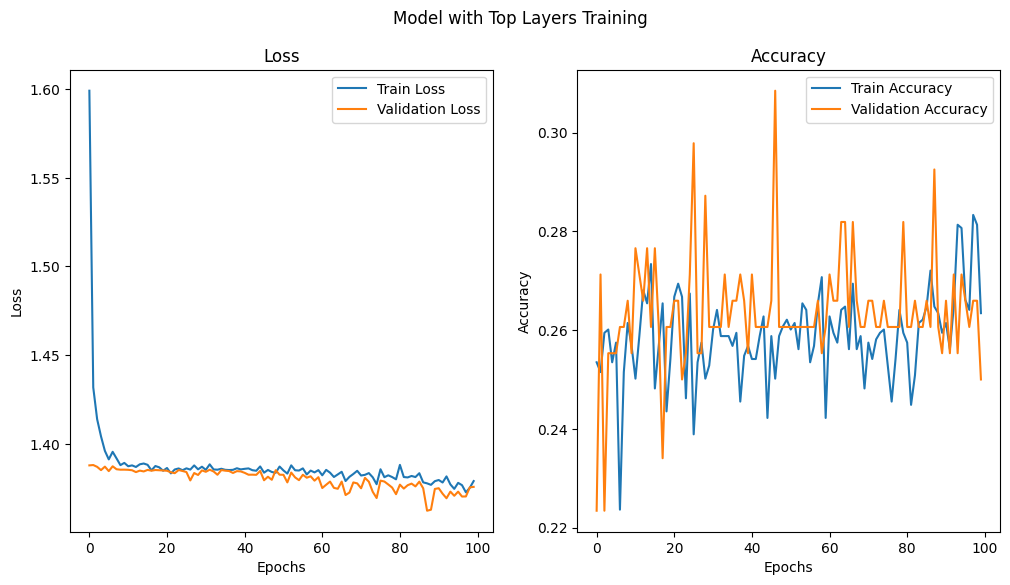

In [20]:
EPOCHS = 100
BATCH_SIZE = 32
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)  # Форма изображений
NUM_CLASSES = len([f for f in train_path.iterdir() if f.is_dir()])

# Загрузка предварительно обученной модели ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

# Заморозим все слои
base_model.trainable = False

# Добавление новых полносвязных слоев
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

class EpochMetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{EPOCHS} - loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")

model_2a = Model(inputs=base_model.input, outputs=predictions)
model_2a.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_2a = model_2a.fit(
    train_images_2,
    train_labels_2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(val_images_2, val_labels_2),
    callbacks=[EpochMetricsCallback()]
    )

test_loss, test_accuracy = model_2a.evaluate(test_images_2, test_labels_2, verbose=0)
print('---' * 30)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

plot_history(history_2a, 'Model with Top Layers Training')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


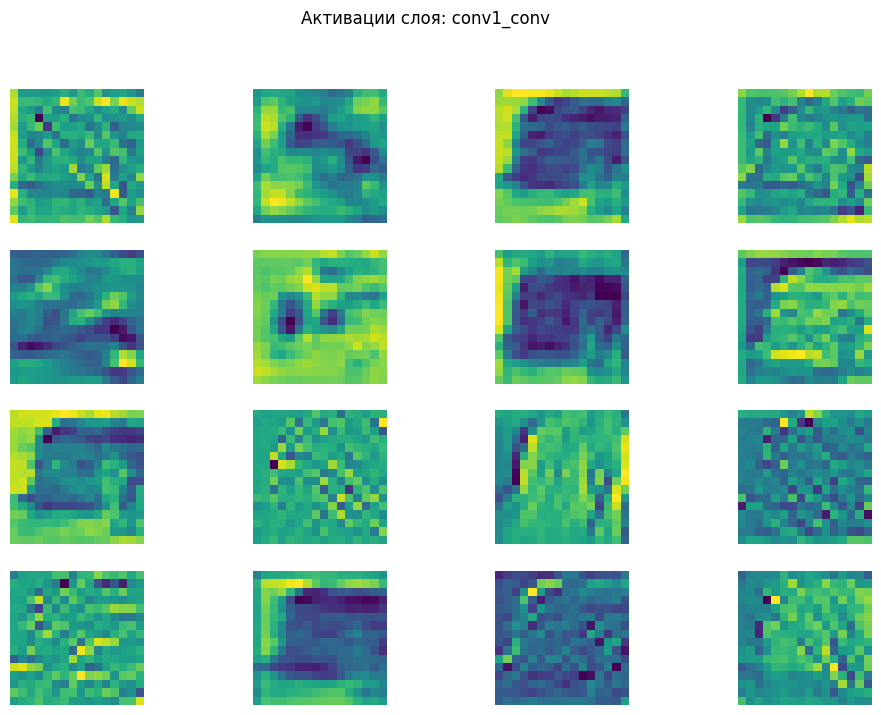

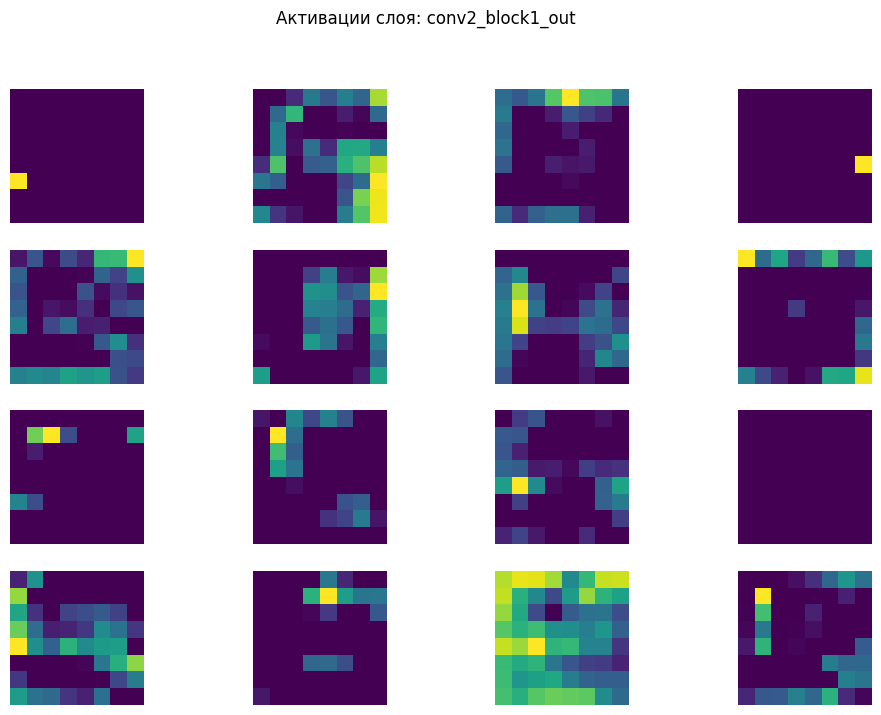

In [21]:
# 1. Визуализация промежуточных активаций
def visualize_activations(model, img_array, layer_names):
    layer_outputs = [model.get_layer(name).output for name in layer_names]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(img_array)

    for layer_name, layer_activation in zip(layer_names, activations):
        num_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]

        plt.figure(figsize=(12, 8))
        for i in range(min(16, num_features)):  # Показываем первые 16 карт активации
            plt.subplot(4, 4, i + 1)
            plt.imshow(layer_activation[0, :, :, i], cmap='viridis')
            plt.axis('off')
        plt.suptitle(f'Активации слоя: {layer_name}')
        plt.show()

# Выбираем одно изображение из каждого класса
sample_images = []
for class_dir in train_path.iterdir():
    if class_dir.is_dir():
        sample_images.append(image.load_img(list(class_dir.glob('*.jpg'))[0], target_size=(IMG_HEIGHT, IMG_WIDTH)))

sample_arrays = np.array([preprocess_input(image.img_to_array(img)) for img in sample_images])
visualize_activations(model_2a, sample_arrays, ["conv1_conv", "conv2_block1_out"])


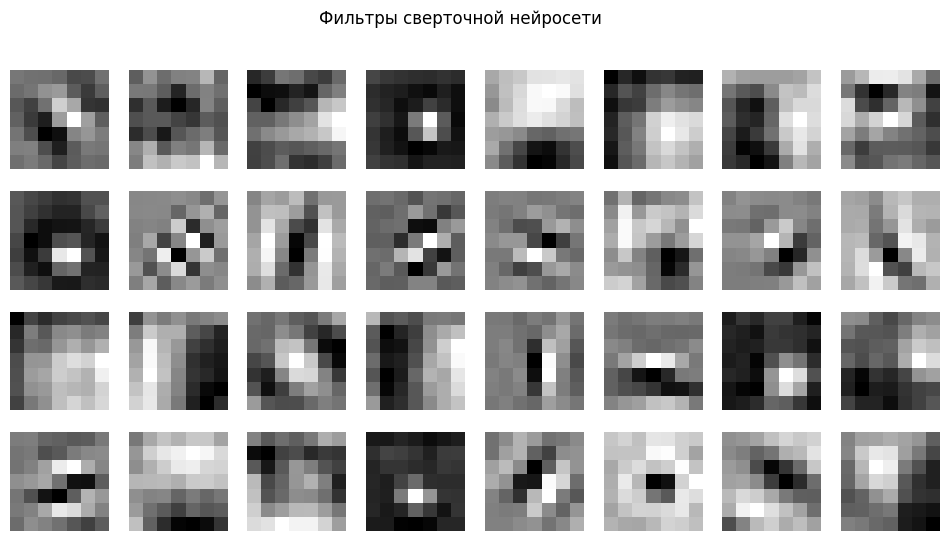

In [22]:
# 2. Визуализация фильтров сверточной нейронной сети
def visualize_filters(model):
    first_conv_layer = model.get_layer("conv1_conv")
    filters, biases = first_conv_layer.get_weights()

    fig, axes = plt.subplots(4, 8, figsize=(12, 6))
    axes = axes.ravel()

    for i in range(32):  # Визуализируем первые 32 фильтра
        f_min, f_max = filters[:, :, :, i].min(), filters[:, :, :, i].max()
        filter_img = (filters[:, :, :, i] - f_min) / (f_max - f_min)  # Нормализация

        axes[i].imshow(filter_img[:, :, 0], cmap='gray')
        axes[i].axis('off')

    plt.suptitle("Фильтры сверточной нейросети")
    plt.show()

visualize_filters(model_2a)


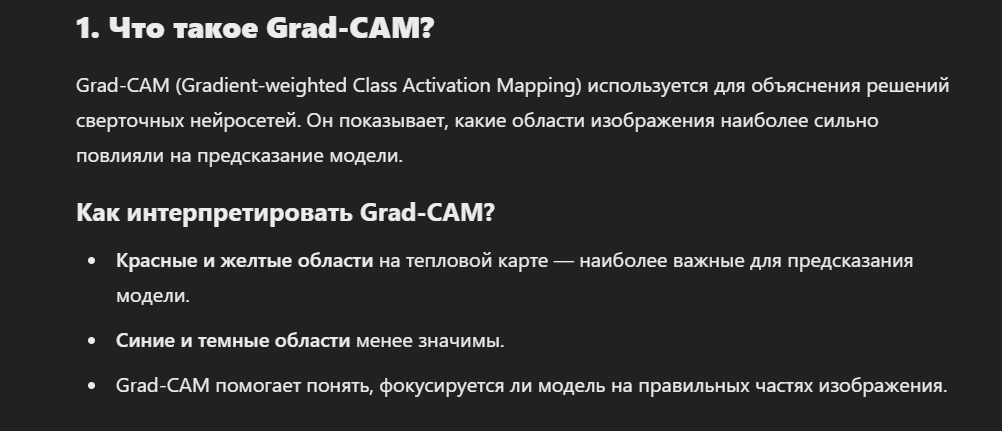

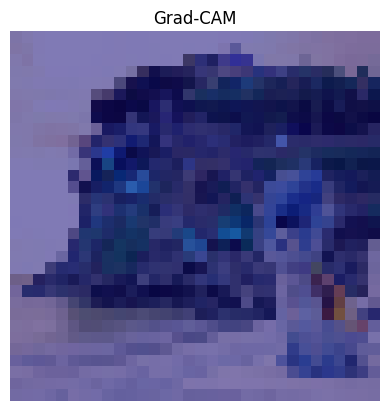

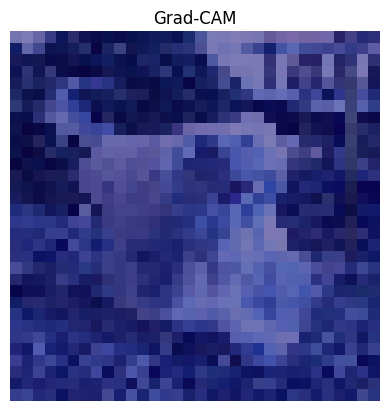

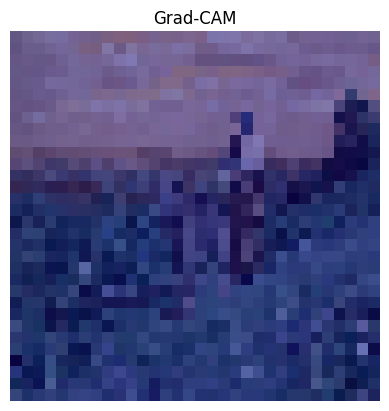

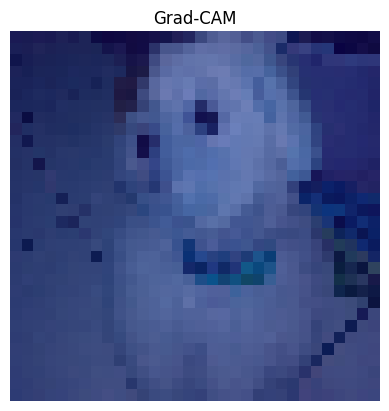

In [23]:
def grad_cam(model, img_array, layer_name):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)[0]

    # Исправление: нормализация heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-8)  # Добавляем небольшое значение, чтобы избежать деления на 0

    # Масштабирование heatmap до размеров изображения
    heatmap = tf.image.resize(heatmap[..., np.newaxis], (IMG_HEIGHT, IMG_WIDTH))
    heatmap = tf.squeeze(heatmap)

    # Корректное наложение тепловой карты на изображение
    img = img_array[0] - img_array[0].min()  # Приводим значения к диапазону [0, 255]
    img /= img.max()  # Масштабируем к [0, 1]

    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title(f'Grad-CAM')
    plt.show()

img_sample = np.expand_dims(sample_arrays[0], axis=0)
grad_cam(model_2a, img_sample, "conv5_block3_out")

img_sample = np.expand_dims(sample_arrays[1], axis=0)
grad_cam(model_2a, img_sample, "conv5_block3_out")

img_sample = np.expand_dims(sample_arrays[2], axis=0)
grad_cam(model_2a, img_sample, "conv5_block3_out")

img_sample = np.expand_dims(sample_arrays[3], axis=0)
grad_cam(model_2a, img_sample, "conv5_block3_out")


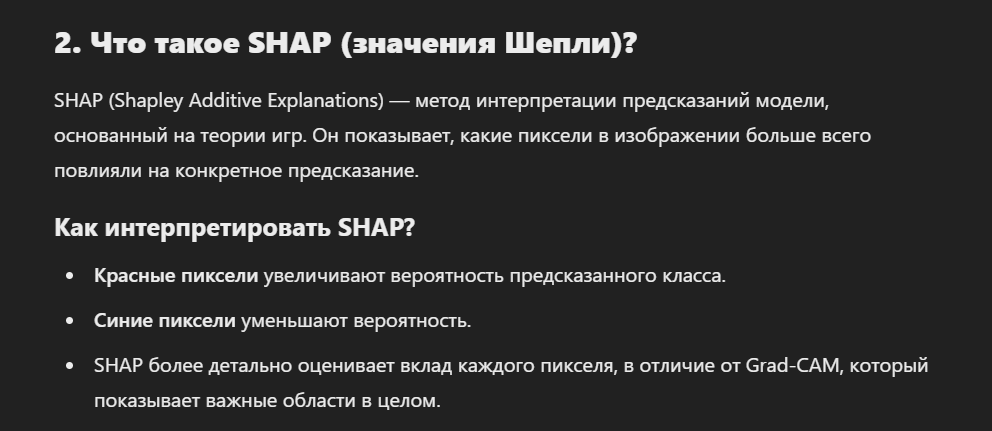

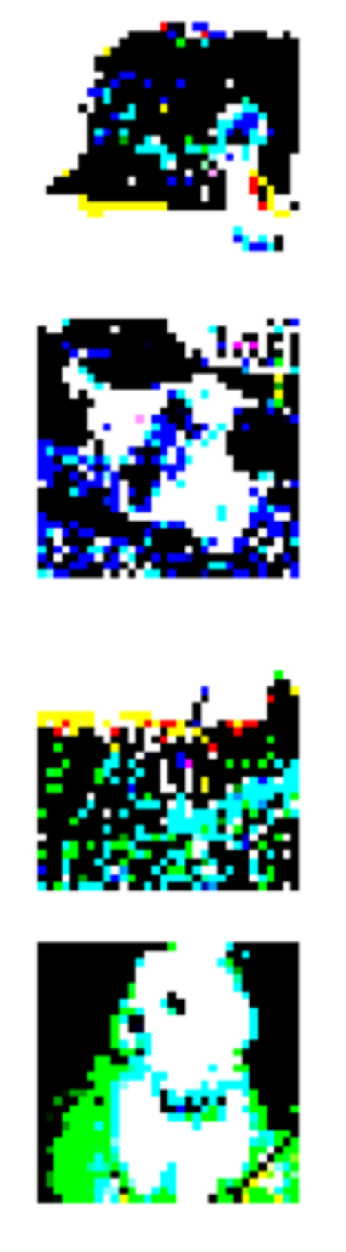

In [34]:
# Преобразование данных из диапазона [-1, 1] в [0, 1]
sample_arrays_norm = np.array([(img + 1) / 2 for img in sample_arrays])

# SHAP анализ
explainer = shap.GradientExplainer(model_2a, sample_arrays_norm[:10])
shap_values = explainer.shap_values(sample_arrays_norm[:4])  # Для первых 4 изображений

# Визуализация и удаление лишних осей
shap.image_plot(shap_values, sample_arrays_norm[:4])  # Отображаем для 4 изображений
fig = plt.gcf()
for ax in fig.axes[1:]:  # Удаляем все оси, кроме первой (левой)
    ax.remove()
plt.show()


### <h1 id="aa" style="color:white;background:#42aaff;padding:8px;border-radius:8px;font-family:newtimeroman;"> 2b fine-tuning</h1>


Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.2677 - loss: 1.8760Epoch 1/100 - loss: 1.7951 - accuracy: 0.2555 - val_loss: 1997.3937 - val_accuracy: 0.2447
48/48 ━━━━━━━━━━━━━━━━━━━━ 86s 637ms/step - accuracy: 0.2674 - loss: 1.8744 - val_accuracy: 0.2447 - val_loss: 1997.3937
Epoch 2/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2422 - loss: 1.8133Epoch 2/100 - loss: 1.6854 - accuracy: 0.2369 - val_loss: 1.3996 - val_accuracy: 0.2553
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.2420 - loss: 1.8081 - val_accuracy: 0.2553 - val_loss: 1.3996
Epoch 3/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2588 - loss: 1.5943Epoch 3/100 - loss: 1.5845 - accuracy: 0.2687 - val_loss: 28.6245 - val_accuracy: 0.2606
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.2592 - loss: 1.5939 - val_accuracy: 0.2606 - val_loss: 28.6245
Epoch 4/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2431 - loss: 1.5231Epoch 4/100 - loss: 1.5137 - accuracy

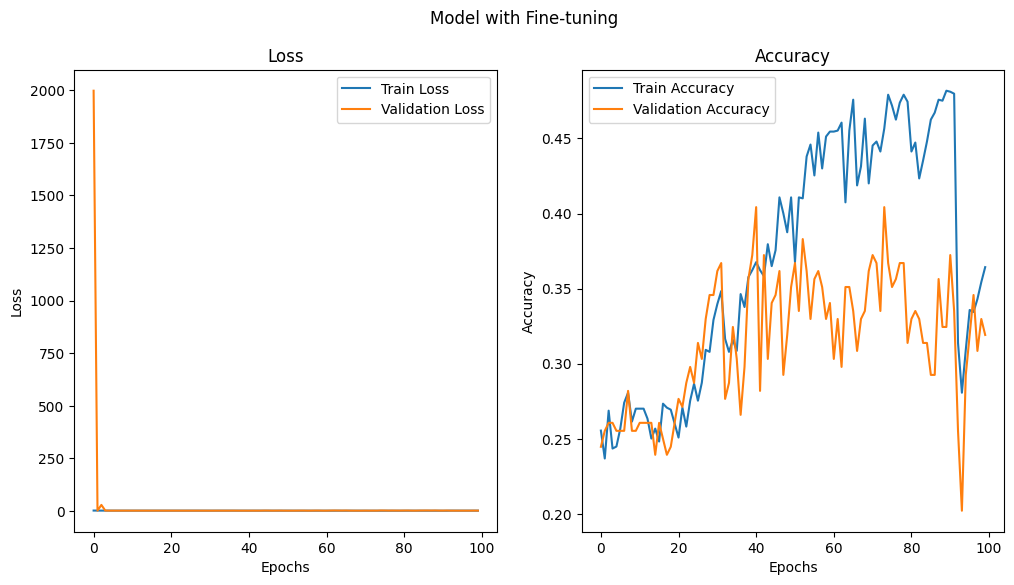

In [25]:
EPOCHS = 100
BATCH_SIZE = 32
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)  # Форма изображений
NUM_CLASSES = len([f for f in train_path.iterdir() if f.is_dir()])

# Загрузка предварительно обученной модели ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

# Разморозим все слои
base_model.trainable = True

# Добавление новых полносвязных слоев
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

class EpochMetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{EPOCHS} - loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")

model_2b = Model(inputs=base_model.input, outputs=predictions)
model_2b.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_2b = model_2b.fit(
    train_images_2,
    train_labels_2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(val_images_2, val_labels_2),
    callbacks=[EpochMetricsCallback()]
    )

test_loss, test_accuracy = model_2b.evaluate(test_images_2, test_labels_2, verbose=0)
print('---' * 30)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

plot_history(history_2b, 'Model with Fine-tuning')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


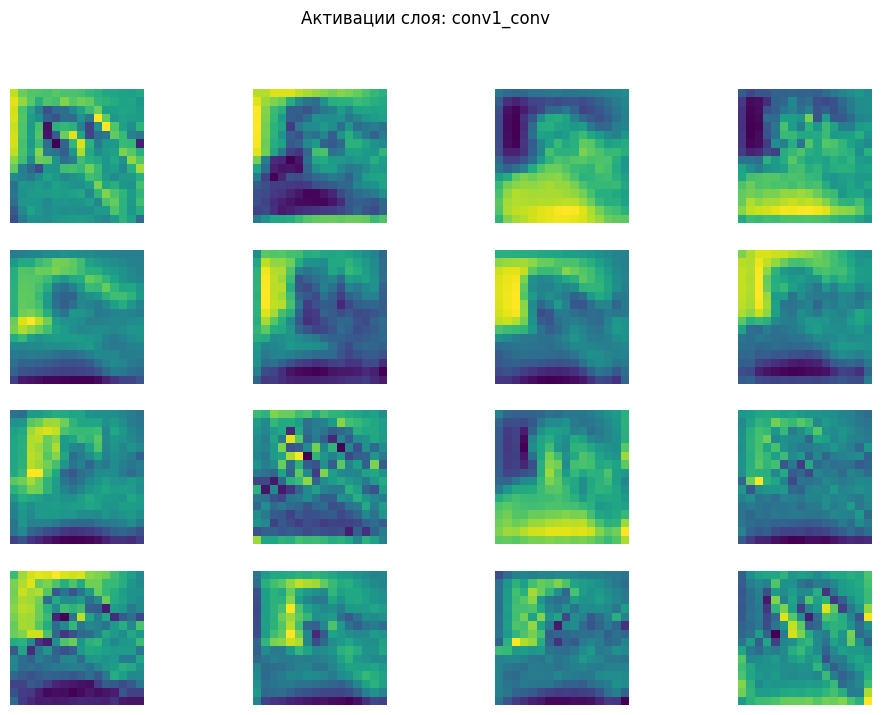

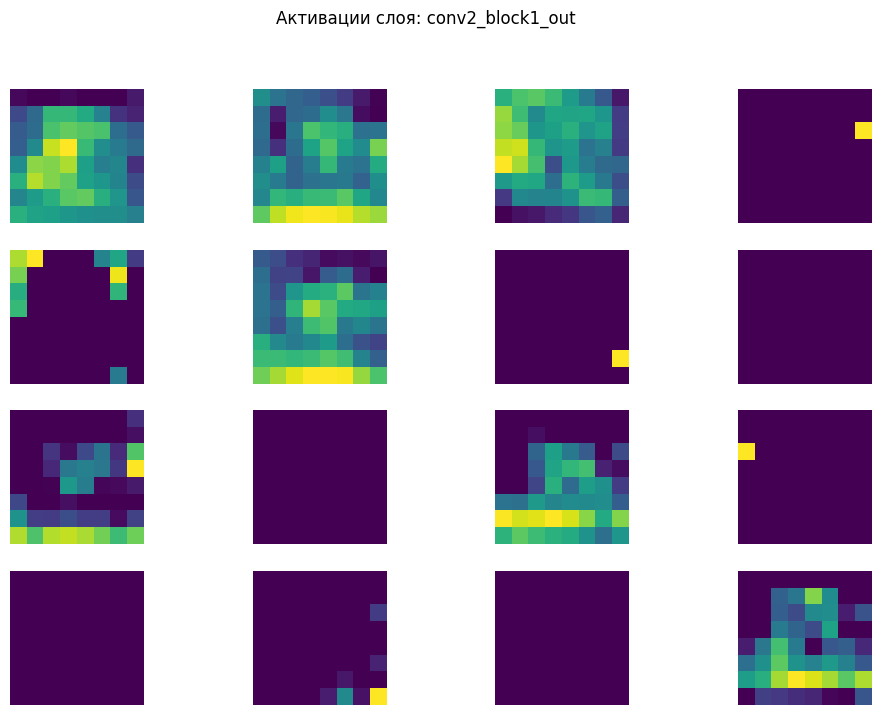

In [26]:
# 1. Визуализация промежуточных активаций
def visualize_activations(model, img_array, layer_names):
    layer_outputs = [model.get_layer(name).output for name in layer_names]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(img_array)

    for layer_name, layer_activation in zip(layer_names, activations):
        num_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]

        plt.figure(figsize=(12, 8))
        for i in range(min(16, num_features)):  # Показываем первые 16 карт активации
            plt.subplot(4, 4, i + 1)
            plt.imshow(layer_activation[0, :, :, i], cmap='viridis')
            plt.axis('off')
        plt.suptitle(f'Активации слоя: {layer_name}')
        plt.show()

num_samples_per_class = 4

# Выбираем случайные изображения из каждого класса
sample_images = []
for class_dir in train_path.iterdir():
    if class_dir.is_dir():
        # Получаем все изображения в классе
        class_images = list(class_dir.glob('*.jpg'))
        selected_images = random.sample(class_images, min(num_samples_per_class, len(class_images)))

        # Загружаем выбранные изображения и добавляем в список
        for img_path in selected_images:
            sample_images.append(image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)))

sample_arrays = np.array([preprocess_input(image.img_to_array(img)) for img in sample_images])

sample_arrays = np.array([preprocess_input(image.img_to_array(img)) for img in sample_images])
visualize_activations(model_2b, sample_arrays, ["conv1_conv", "conv2_block1_out"])


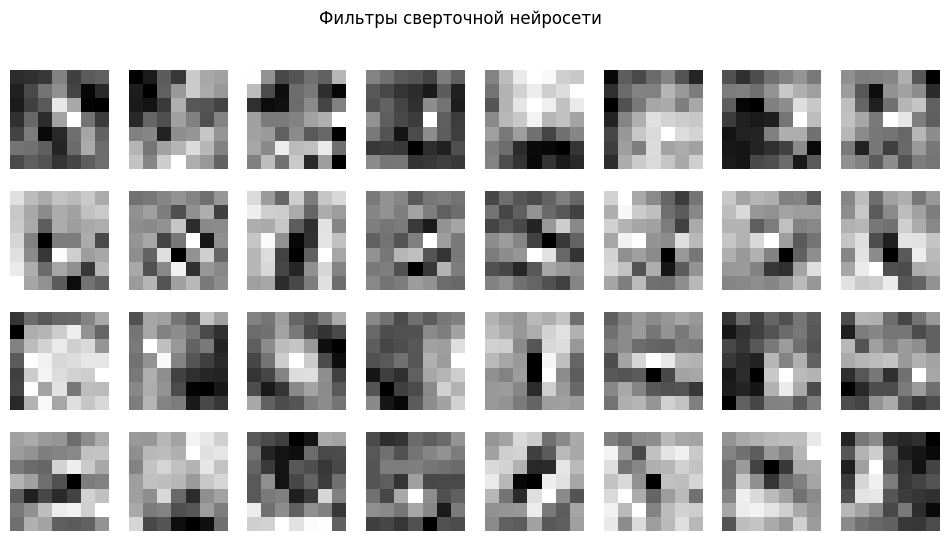

In [27]:
# 2. Визуализация фильтров сверточной нейронной сети
def visualize_filters(model):
    first_conv_layer = model.get_layer("conv1_conv")
    filters, biases = first_conv_layer.get_weights()

    fig, axes = plt.subplots(4, 8, figsize=(12, 6))
    axes = axes.ravel()

    for i in range(32):  # Визуализируем первые 32 фильтра
        f_min, f_max = filters[:, :, :, i].min(), filters[:, :, :, i].max()
        filter_img = (filters[:, :, :, i] - f_min) / (f_max - f_min)  # Нормализация

        axes[i].imshow(filter_img[:, :, 0], cmap='gray')
        axes[i].axis('off')

    plt.suptitle("Фильтры сверточной нейросети")
    plt.show()

visualize_filters(model_2b)


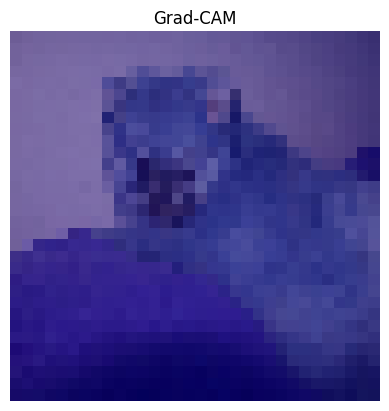

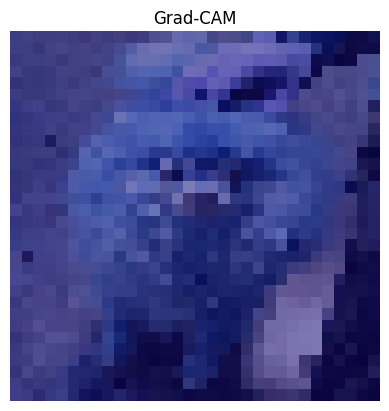

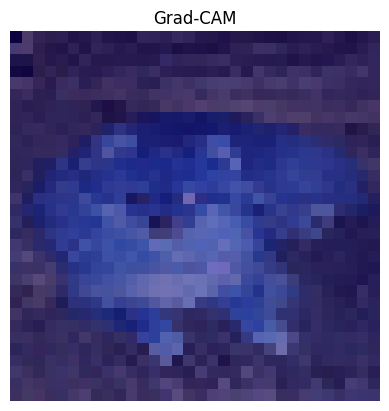

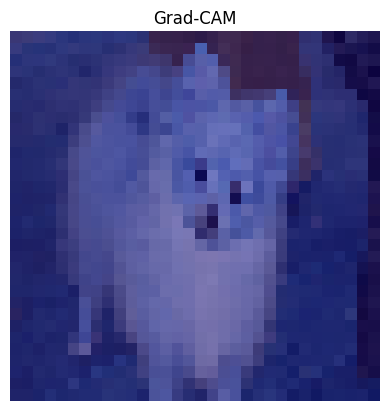

In [28]:
# 3. Grad-CAM
def grad_cam(model, img_array, layer_name):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)[0]

    # Исправление: нормализация heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-8)  # Добавляем небольшое значение, чтобы избежать деления на 0

    # Масштабирование heatmap до размеров изображения
    heatmap = tf.image.resize(heatmap[..., np.newaxis], (IMG_HEIGHT, IMG_WIDTH))
    heatmap = tf.squeeze(heatmap)

    # Корректное наложение тепловой карты на изображение
    img = img_array[0] - img_array[0].min()  # Приводим значения к диапазону [0, 255]
    img /= img.max()  # Масштабируем к [0, 1]

    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title(f'Grad-CAM')
    plt.show()

img_sample = np.expand_dims(sample_arrays[0], axis=0)
grad_cam(model_2b, img_sample, "conv5_block3_out")

img_sample = np.expand_dims(sample_arrays[1], axis=0)
grad_cam(model_2b, img_sample, "conv5_block3_out")

img_sample = np.expand_dims(sample_arrays[2], axis=0)
grad_cam(model_2b, img_sample, "conv5_block3_out")

img_sample = np.expand_dims(sample_arrays[3], axis=0)
grad_cam(model_2b, img_sample, "conv5_block3_out")


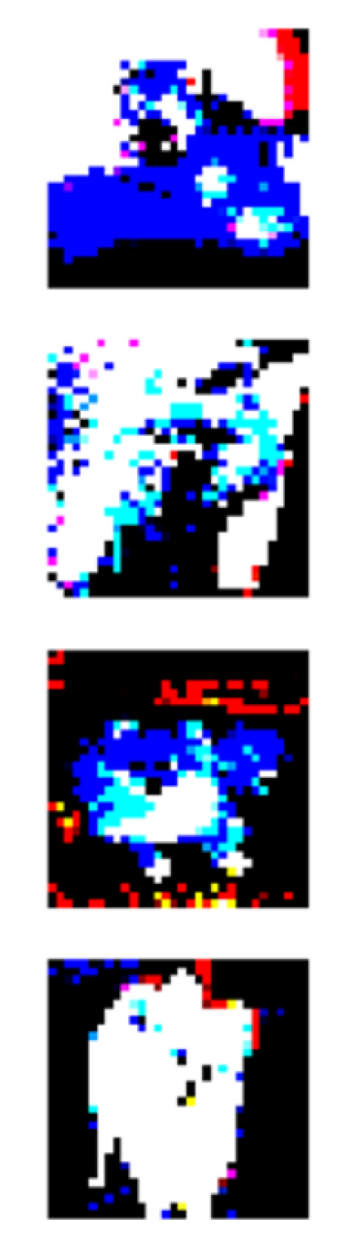

In [32]:
# Преобразование данных из диапазона [-1, 1] в [0, 1]
sample_arrays_norm = np.array([(img + 1) / 2 for img in sample_arrays])

# SHAP анализ
explainer = shap.GradientExplainer(model_2a, sample_arrays_norm[:10])
shap_values = explainer.shap_values(sample_arrays_norm[:4])  # Для первых 4 изображений

# Визуализация и удаление лишних осей
shap.image_plot(shap_values, sample_arrays_norm[:4])  # Отображаем для 4 изображений
fig = plt.gcf()
for ax in fig.axes[1:]:  # Удаляем все оси, кроме первой (левой)
    ax.remove()
plt.show()
